In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Question 1 & 2

In [2]:
df_2_1 = pd.read_csv('homework_2.1.csv')

In [13]:
def fixed_effect_regression(data, outcome):
    X = sm.add_constant(data["time"])  # Adding intercept
    y = data[outcome]
    model = sm.OLS(y, X).fit()
    return model.summary()

print(fixed_effect_regression(df_2_1, "G1"))
# print(fixed_effect_regression(df_2_1, "G2"))
# print(fixed_effect_regression(df_2_1, "G3"))

                            OLS Regression Results                            
Dep. Variable:                     G1   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     23.40
Date:                Fri, 30 May 2025   Prob (F-statistic):           4.90e-06
Time:                        16:00:36   Log-Likelihood:                -72.993
No. Observations:                 100   AIC:                             150.0
Df Residuals:                      98   BIC:                             155.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1042      0.101      1.035      0.3

In [3]:
# Reshape to long format
df_long = df_2_1.melt(id_vars=['time'], value_vars=['G1', 'G2', 'G3'], 
                 var_name='group', value_name='outcome')

# Fit fixed effects regression: outcome ~ time + group
model_2_1 = smf.ols('outcome ~ time + C(group)', data=df_long).fit()
print(model_2_1.summary())

# Display estimated fixed effects for each group
fe = model_2_1.params.filter(like='C(group)')
print('\nFixed effects for each group:')
print(fe)

# Display the coefficient for time
print(f"\nCoefficient for time: {model_2_1.params['time']}")

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     44.55
Date:                Fri, 30 May 2025   Prob (F-statistic):           8.72e-24
Time:                        14:14:02   Log-Likelihood:                -216.89
No. Observations:                 300   AIC:                             441.8
Df Residuals:                     296   BIC:                             456.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0786      0.071      1.

In [7]:
df_long.head

<bound method NDFrame.head of      time group   outcome
0       0    G1  0.882026
1       1    G1  0.210079
2       2    G1  0.509369
3       3    G1  1.150447
4       4    G1  0.973779
..    ...   ...       ...
295    95    G3  1.768446
296    96    G3  1.258862
297    97    G3  1.511477
298    98    G3  1.030275
299    99    G3  1.425028

[300 rows x 3 columns]>

## Question 3-5

In [4]:
df_2_2 = pd.read_csv('homework_2.2.csv')

Bootstrap mean difference: 2.924
95% CI: [2.569, 3.285]


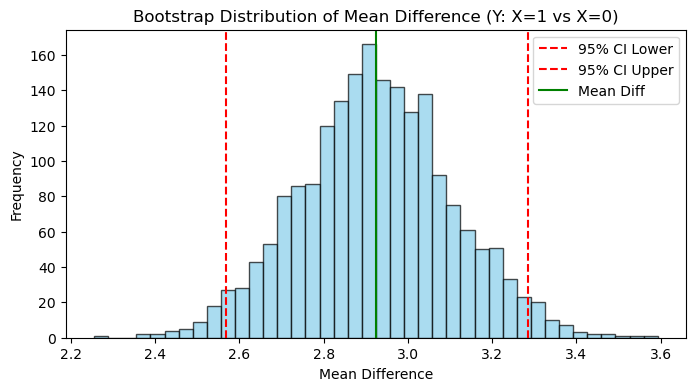

In [5]:
# Bootstrap simulation for mean difference in Y between X=1 and X=0
def bootstrap_mean_diff(df, n_bootstrap=1000, random_state=42):
    np.random.seed(random_state)
    diffs = []
    group1 = df[df['X'] == 1]['Y'].values
    group0 = df[df['X'] == 0]['Y'].values
    n1 = len(group1)
    n0 = len(group0)
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample0 = np.random.choice(group0, size=n0, replace=True)
        diffs.append(sample1.mean() - sample0.mean())
    return np.array(diffs)

# Run bootstrap
boot_diffs = bootstrap_mean_diff(df_2_2, n_bootstrap=2000)

# Calculate 95% confidence interval
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)
mean_diff = boot_diffs.mean()

print(f"Bootstrap mean difference: {mean_diff:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# Plot the bootstrap distribution
plt.figure(figsize=(8,4))
plt.hist(boot_diffs, bins=40, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI Lower')
plt.axvline(ci_upper, color='red', linestyle='--', label='95% CI Upper')
plt.axvline(mean_diff, color='green', linestyle='-', label='Mean Diff')
plt.title('Bootstrap Distribution of Mean Difference (Y: X=1 vs X=0)')
plt.xlabel('Mean Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [6]:
mean_treated = df_2_2[df_2_2['X'] == 1]['Y'].mean()
mean_untreated = df_2_2[df_2_2['X'] == 0]['Y'].mean()
simple_diff = mean_treated - mean_untreated

print(f"Mean outcome (Treated, X=1): {mean_treated:.3f}")
print(f"Mean outcome (Untreated, X=0): {mean_untreated:.3f}")
print(f"Simple difference in means (Treated - Untreated): {simple_diff:.3f}")

Mean outcome (Treated, X=1): 7.843
Mean outcome (Untreated, X=0): 4.922
Simple difference in means (Treated - Untreated): 2.921


In [14]:
variance = np.var(boot_diffs, ddof=1)
print(f"Bootstrap variance of the mean difference: {variance:.5f}")

Bootstrap variance of the mean difference: 0.03271


In [15]:
from scipy.stats import skew

def bootstrap_regression_coef(df, n_bootstrap=1000, random_state=42):
    np.random.seed(random_state)
    coefs = []
    for _ in range(n_bootstrap):
        sample = df.sample(frac=1, replace=True)
        model = sm.OLS(sample['Y'], sm.add_constant(sample['X'])).fit()
        coefs.append(model.params['X'])
    return np.array(coefs)

boot_coefs = bootstrap_regression_coef(df_2_2, n_bootstrap=2000)
skewness = skew(boot_coefs)
print(f"Bootstrap skewness of regression effect: {skewness:.5f}")

Bootstrap skewness of regression effect: 0.09555
